In [ ]:
import pandas as pd
import numpy as np
import datetime
import tqdm #進度條
import talib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data = pd.read_csv('data/1019_SP.csv')
Date = data.get("Date")
Date = pd.to_datetime(Date)
Open = data.get("Open")
High = data.get("High")
Low = data.get("Low")
Close = data.get("Close")

dict = {"Date": Date,
        "open": Open,
        "high": High,
        "low": Low, 
        "close": Close
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,open,high,low,close
Date,,,,
2019-12-13,3166.649902,3182.679932,3156.510010,3168.800049
2019-12-16,3183.629883,3197.709961,3183.629883,3191.449951
2019-12-17,3195.399902,3198.219971,3191.030029,3192.520020
2019-12-18,3195.209961,3198.479980,3191.139893,3191.139893
2019-12-19,3192.320068,3205.479980,3192.320068,3205.370117
2019-12-20,3223.330078,3225.649902,3216.030029,3221.219971
2019-12-23,3226.050049,3227.780029,3222.300049,3224.010010
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020


In [ ]:
ema = talib.EMA(df['close'])
sma = talib.SMA(df['close'])
roc = talib.ROC(df['close'])
macd, macdsignal, macdhist = talib.MACD(df['close'])
k, d = talib.STOCH (df['high'], df['low'], df['close'])
upper, middle, lower = talib.BBANDS(df['close'])
B = (df['close'] - lower)/(upper - lower)

dataset = pd.DataFrame({
    'Close':df['close'],    
    'EMA':ema,
    'SMA':sma,
    'ROC':roc,
    'MACD':macd,
    '%K':k,
    '%D':d,
    'Upper Band':upper,
    'Lower Band':lower,
    '%B':B,
    'return': df['close'].shift(-10) / df['close'],
})

feature_names = list(dataset.columns[:-1])

In [ ]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 11)
after dropping NaN (2450, 11)


In [ ]:
import lightgbm as lgb
dataset_train = dataset[:'2018']
dataset_test = dataset['2019':]

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

train = (dataset_train[feature_names], dataset_train['return'] > 1)
test = (dataset_test[feature_names], dataset_test['return'] > 1)

gbm.fit(*train)
gbm.score(*test)

0.592436974789916

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,EMA,SMA,ROC,MACD,%K,%D,Upper Band,Lower Band,%B,return
count,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2.450000e+03,2450.000000
mean,2.608344e-16,1.052945e-15,-7.583956e-16,3.319340e-18,-4.504333e-17,-3.572652e-16,2.353673e-16,-8.118676e-16,8.055234e-16,-4.785288e-17,1.004667
std,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,1.000204e+00,0.025717
min,-1.630499e+00,-1.524931e+00,-1.528389e+00,-6.517844e+00,-4.787126e+00,-2.291631e+00,-2.447524e+00,-1.625795e+00,-1.633177e+00,-1.937682e+00,0.837023
25%,-9.806386e-01,-9.932587e-01,-9.840997e-01,-4.857836e-01,-5.018394e-01,-7.983158e-01,-7.850271e-01,-9.894832e-01,-9.894527e-01,-9.039628e-01,0.992184
50%,3.891268e-02,4.650956e-02,3.390802e-02,8.348593e-02,1.754179e-01,1.518818e-01,1.504282e-01,3.314858e-02,3.855468e-02,2.465257e-01,1.006821
75%,8.050955e-01,8.128251e-01,8.098827e-01,6.181626e-01,6.361433e-01,8.998069e-01,8.761148e-01,7.855806e-01,8.216533e-01,8.504395e-01,1.020581
max,2.074933e+00,1.995103e+00,2.003194e+00,3.412374e+00,2.683757e+00,1.491689e+00,1.537541e+00,2.025528e+00,2.051472e+00,1.542731e+00,1.092456


In [ ]:
from keras.utils import np_utils
n = 20

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    r = dataset_scaled['return'].iloc[i+n-1]
    if r >1:
      r = 0
    else:
      r = 1
    rr = np_utils.to_categorical(r, num_classes=2)
    y.append(rr)
    indexes.append(dataset_scaled.index[i+n-1])

X = np.array(X)
y = np.array(y)
indexes = np.array(indexes)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
X_train = X[indexes < datetime.datetime(2019, 1, 1)]
y_train = y[indexes < datetime.datetime(2019, 1, 1)]
x_validation = X[indexes > datetime.datetime(2019,1,1)]
y_validation = y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=X_train[0].shape))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           71168     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 206,946
Trainable params: 206,946
Non-trainable params: 0
__________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(X_train,y_train,
                    batch_size=100,
                    epochs=250,
                    verbose=1,
                    validation_split = 0.2,
                    callbacks=[earlystop],
                    )

Epoch 1/250
18/18 [==============================] - 1s 47ms/step - loss: 0.6754 - accuracy: 0.5941 - val_loss: 0.6876 - val_accuracy: 0.6743
Epoch 2/250
18/18 [==============================] - 0s 10ms/step - loss: 0.6599 - accuracy: 0.6152 - val_loss: 0.6997 - val_accuracy: 0.5581
Epoch 3/250
18/18 [==============================] - 0s 9ms/step - loss: 0.6592 - accuracy: 0.6237 - val_loss: 0.6565 - val_accuracy: 0.6743
Epoch 4/250
18/18 [==============================] - 0s 8ms/step - loss: 0.6500 - accuracy: 0.6311 - val_loss: 0.6658 - val_accuracy: 0.6355
Epoch 5/250
18/18 [==============================] - 0s 9ms/step - loss: 0.6400 - accuracy: 0.6277 - val_loss: 0.6650 - val_accuracy: 0.6811
Epoch 6/250
18/18 [==============================] - 0s 8ms/step - loss: 0.6323 - accuracy: 0.6534 - val_loss: 0.7099 - val_accuracy: 0.6765
Epoch 7/250
18/18 [==============================] - 0s 9ms/step - loss: 0.6247 - accuracy: 0.6648 - val_loss: 0.8282 - val_accuracy: 0.6651
Epoch 8/250

In [ ]:
o_loss,o_accuracy = model.evaluate(X_train,y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(x_validation,y_validation)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

69/69 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.7301
對訓練資料的：
Loss: 0.63, Accuracy: 0.73
8/8 [==============================] - 0s 3ms/step - loss: 1.1335 - accuracy: 0.6751
對測試資料的：
Loss: 1.13, Accuracy: 0.68


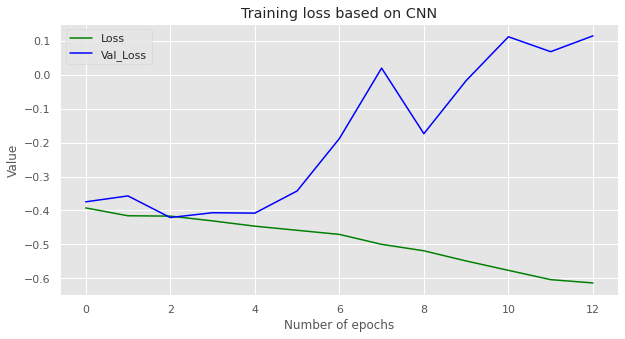

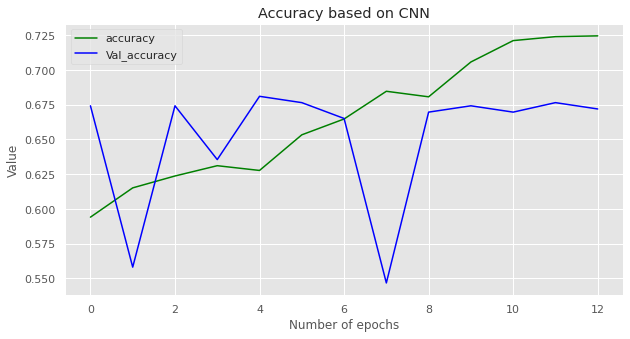

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.log(history.history['loss']), color = 'green', label='Loss')
plt.plot(np.log(history.history['val_loss']), color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='Val_accuracy')
plt.legend()
plt.title('Accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


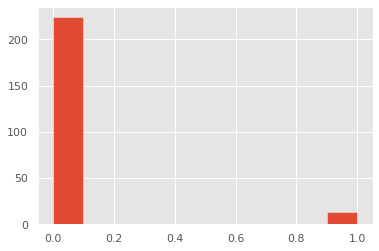

In [ ]:
pre = model.predict_classes(x_validation)
pre = pd.Series(pre)
pre.hist()

TP: 160.00, FN: 13.00, FP: 64.00, TN: 0.00
對訓練集資料的：Loss: 0.63, Accuracy: 0.73
對測試集資料的：Loss: 1.13, Accuracy: 0.68

測試資料總共：237.00 筆, 其中漲的筆數為: 0.00, 全部猜漲猜對的機率是: 0.00
該測試集資料的：
Accuracy: 0.68, Precision: 0.71, Recall: 0.92
F1 score: 0.81


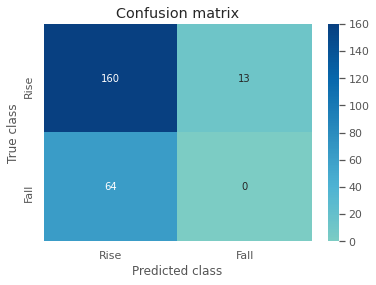

In [ ]:
from sklearn.metrics import confusion_matrix

#將onehot編碼轉回數組cnn_x_validation
y_validation = np.argmax(y_validation, axis=1)
xy_validation = pd.Series(y_validation)

LABELS = ["Rise","Fall"]
conf_matrix = confusion_matrix(xy_validation, pre)

t_size = len(y_validation)
t_size1 = (y_validation>1).sum()
t_guess = ((y_validation>1).sum())/(len(y_validation))

TP = conf_matrix[0][0]
FN = conf_matrix[0][1]
FP = conf_matrix[1][0]
TN = conf_matrix[1][1]
accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))
print("TP: %.2f, FN: %.2f, FP: %.2f, TN: %.2f" % (TP,FN,FP,TN))
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆, 其中漲的筆數為: %.2f, 全部猜漲猜對的機率是: %.2f" % (t_size, t_size1, t_guess))
print("該測試集資料的：\nAccuracy: %.2f, Precision: %.2f, Recall: %.2f\nF1 score: %.2f" % (accuracy, precision,recall,F1))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
def updown(predict):
  data = []
  for i in range(len(y_validation)):
    if pre[i]>0.5:
      data.append(1)
    else:
      data.append(0)
  return data

In [ ]:
pre = np.array(updown(pre))